Input index of starting city: 0
Input the indices of all destination cities (separate with spaces, no commas): 1 2 3
Input graph name (omit .csv): coordinate1


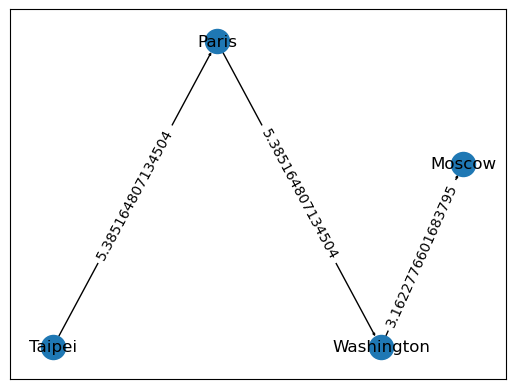

None


In [11]:
import csv
import numpy as np
import random
import networkx as nx
import math
import time
import matplotlib.pyplot as plt
import copy

infinity = float('inf') #not really necessary in retrospect but I don't want to change it

def dijkstra(city, adjarray, carray): #takes in a starting city index, array of city information, adj mat
    carray[city][5] = True #mark city as visited
    visit = [] #list of adj cities to visit
    for k in (range(len(adjarray))):
        if adjarray[city][k] != 0:
            visit.append(k) #if connection, add to visit
            if carray[k][0] > (adjarray[city][k] + carray[city][0]): #if new path is shorter than old
                carray[k][0] = (adjarray[city][k] + carray[city][0]) #set old to new
                carray[k][1] = city #mark second to last city in path
    for element in visit: #for adj city
        if carray[element][5] == False: #if city has not already been visited
            dijkstra(element, adjarray, carray) #recurse on adjacent city
            
def floyd_warshall(array_org): #performed only on array, no extra information necessary
    array_new = np.asfarray(array_org.copy()) #will contain length of shortest paths
    bigcarray = np.full_like(array_org.copy(), infinity) #contains second to last node in path, or infinity
    for k in (range(len(array_new))):
        for j in range(len(array_new)):
            if k == j:
                array_new[k][j] = 0 #distance from node to itself = 0 always
                bigcarray[k][j] = k #second to last node in path is itself
            elif k != j and array_new[k][j] == 0:
                array_new[k][j] = infinity #if no direct connection, set as inf initially
            else:
                bigcarray[k][j] = k #last node in path of direct connections
    for pivot in range(len(array_new)): #will be used as intermediary node
        for v1 in range(len(array_new)): #starting node
            for v2 in range(len(array_new)): #final node
                if array_new[v1][v2] > array_new[v1][pivot] + array_new[pivot][v2]: #if the new calculated length is shorter than the current
                    array_new[v1][v2] = array_new[v1][pivot] + array_new[pivot][v2] #set current = new
                    bigcarray[v1][v2] = bigcarray[pivot][v2] #record second to last node in path
    return array_new, bigcarray #returns a new array containing distances, as well as an array for pathing

def randomgraph(vertices, connection_chance, width, height): #just creates a random graph and dictionary for testing
    randarray = []
    for i in range(vertices * vertices): #v * v is total elements in array
        connect = random.uniform(0, 1) #determines if connecting occurs
        if connect >= connection_chance: #if no connection
            randarray.append(float(0)) #edge does not exist
        else:
            randarray.append(float(1)) #edge exists
    randarray = np.reshape(randarray, (vertices, vertices))
    carray = [] #will contain information on city
    for k in range(vertices): #create positions based on width and height input
        carray.append([infinity, '', f'{k}', random.uniform(0, width), random.uniform(0, height), False])
        randarray[k][k] = 0 #retroactively set diagonal to 0, because v to v is always 0
    calculatedist(randarray, carray) #calculate distances based on position
    return randarray, carray #return the array and city information array

def advanced_randomgraph(vertices, conn_dist, width, height): #just creates a random graph and dictionary for testing
    randarray = np.ones((vertices, vertices))
    carray = []
    for k in range(vertices): #create positions based on width and height input
        carray.append([infinity, '', f'{k}', random.uniform(0, width), random.uniform(0, height), False])
    calculatedist(randarray, carray)
    for k in range(vertices):
        for j in range(vertices):
            if k == j:
                randarray[k][j] = 0
            elif randarray[k][j] > conn_dist:
                randarray[k][j] = 0
    return randarray, carray
    
def displaygraph(adjarray, carray):
    posi = {} #dictionary of positions of nodes
    edge = {} #dictionary of edge weight labels
    graph = nx.DiGraph()
    for k in range(len(adjarray)): #for all nodes
        posi[carray[k][2]] = (carray[k][3], carray[k][4]) #posi[cityname] = (x, y)
        graph.add_node(carray[k][2]) #graph node
    for k in range(len(adjarray)):
        for j in range(len(adjarray)):
            if adjarray[k][j] != 0: #for all edges
                edge[(carray[k][2], carray[j][2])] = adjarray[k][j] #edge[v1, v2] = weight
                graph.add_edge(carray[k][2], carray[j][2], weight = adjarray[k][j]) #graph edge label
    if len(adjarray) >= 100:
        label = False
        fs = 2
        ns = 10
    elif len(adjarray) >= 50:
        label = False
        fs = 5
        ns = 50
    elif len(adjarray) >= 20:
        label = True
        fs = 7
        ns = 100
    else:
        label = True
        fs = 10
        ns = 300
    nx.draw_networkx(graph, posi, node_size = ns, arrowsize = 3, with_labels = label)
    nx.draw_networkx_edge_labels(graph, posi, edge_labels = edge, font_size = fs)
    plt.show()
    
def calculatedist(adjarray, carray):
    for k in range(len(adjarray)):
        for j in range(len(adjarray)):
            if adjarray[k][j] != 0: #for all edges, do pythagorean theorum
                adjarray[k][j] = math.sqrt((carray[k][3] - carray[j][3]) ** 2 + (carray[k][4] - carray[j][4]) ** 2) 

def read_adj(filename):
    adjarray = []
    carray = [] #array full of city information
    rowcount = 0 #for reshaping array later
    with open(f'{filename}.csv', 'r') as csvfile:
        my_reader = csv.reader(csvfile, delimiter = ',')
        for row in my_reader: #for each node, has current city distance, ind of second to last city of path, position x, y
            carray.append([infinity, infinity, row[0], float(row[1]), float(row[2]), False]) #and if the node has been visited
            for k in range(3, len(row)):
                adjarray.append(float(row[k])) #append adj matrix from file, which begins at ind 3
            rowcount += 1
    adjarray = np.reshape(adjarray, (rowcount, rowcount)) #reshape from vector to matrix, will always be square
    calculatedist(adjarray, carray) #calculate distance based on position, see above
    return adjarray, carray

def path_array_d(adjarray, carray): #create new array containing only connections for shortest paths from city (for dijkstra's)
    parray = np.zeros_like(adjarray, dtype = float) #create new array of 0s
    for i in range(len(adjarray)): # for given city, i = city index
        if carray[i][0] != infinity: # if reachable
            last_city = carray[i][1] #index of second to last city in path
            parray[last_city][i] = adjarray[last_city][i] #add to parray
    return parray #stands for path array

def path_array_fw(adjarray, bigcarray, start_city): #same as above, for floyd-warhsall
    parray = np.zeros_like(adjarray, dtype = float) #create new array of 0s
    row = bigcarray[start_city] #take only relavant row
    for k in range(len(row)):
        if row[k] != infinity: #if reachable
            last_city = int(bigcarray[start_city][k]) #index of second ot last city in path
            parray[last_city][k] = adjarray[last_city][k] #add to parray
    return parray #stands for path array

def timetesting():
    chance = float(input("Input connection chance: "))
    verts = int(input('Input number of vertices: \n'))
    adjarray, carray = randomgraph(verts, chance, 1000, 1000)
    fwstart = time.time()
    fwarray, bigcarray = floyd_warshall(adjarray)
    fwend = time.time()
    dtotal = 0
    for v in range(len(adjarray)):
        carray[v][0] = 0
        dstart = time.time()
        dijkstra(v, adjarray, carray)
        dend = time.time()
        dtotal += (dend - dstart)
        adjarray, carray = randomgraph(verts, chance, 1000, 1000)
    print(f'Floyd-Warshall time elapsed: {fwend - fwstart} seconds.')
    print(f'Dijkstra time elapsed: {dtotal} seconds. \n')

def mult_dest_d(adjarray, carray, destinations, start):
    destinations.insert(0, start) #for iteration
    carraylist = [] #list of deep copies of carray
    orderdict = {}
    for k in range(len(destinations)):
        destinations[k] = int(destinations[k])
        key = int(destinations[k])
        orderdict[key] = k
    for k in range(len(destinations)):
        carraylist.append(copy.deepcopy(carray))
    for k in range(len(destinations)):
        city = int(destinations[k])
        ind = orderdict[city]
        carraylist[ind][ind][0] = 0
        dijkstra(ind, adjarray, carraylist[ind])
    order = copy.deepcopy(destinations)
    mini = infinity
    for k in range(len(destinations)):
        ordersum = 0
        for k in range(len(destinations) - 1):
            ind1 = orderdict[int(order[k])]
            ind2 = orderdict[int(order[k + 1])]
            ordersum += carraylist[ind1][ind2][0]
        if ordersum < mini:
            mini = ordersum
            shortest_order = copy.deepcopy(order)
        order.insert(1, int(order[-1]))
        order.pop(-1)
    parray = np.zeros_like(adjarray)
    for k in range(len(order) - 1):
        city1 = order[k]
        city2 = order[k + 1]
        parray[city1][city2] = 1
    calculatedist(parray, carray)
    displaygraph(parray, carray)
    
def menu(): #just a branching menu for selecting features, self explanatory
    choice = 0 #this did not need to be a function, I know
    while choice != -1:
        choice = float(input("""MENU \n Type a number to select an option: 
    1. Calculate shortest distance between two cities using Dijkstra's Algorithim
    2. Calculate shortest distance between two cities using Floyd-Warshall Algorithim
    3. Display graph
    4. Display fastest paths from starting city
    5. Compare algorithim times
    6. Calculate shortest distance between more than two cities
    Type '-1' to exit"""))
        if choice == 1:
            print("Use (1.) downloaded graph or (2.) generate one randomly?")
            randomchoice = float(input())
            if randomchoice == 1:
                print("Input graph name (omit .csv): ")
                filename = input()
                adjarray, carray = read_adj(filename)
                print("Input index of starting city: ")
                start_city = int(input())
                carray[start_city][0] = 0 #starting city has distance 0, must be done outside of function because
                print("Input index of destination city: ") #the function is recursive; similar below
                end_city = int(input())
                dijkstra(start_city, adjarray, carray)
                print(f'The fastest route from {carray[start_city][2]} to {carray[end_city][2]} is {carray[end_city][0]} units long.')
            elif randomchoice == 2:
                verts = int(input("How many vertices? \n"))
                conn = float(input("What is the chance of an edge between two vertices? (from 0 - 1)"))
                width = float(input("What is the width of the graph?"))
                height = float(input("What is the height of the graph?"))
                adjarray, carray = randomgraph(verts, conn, width, height)
                start_city = int(input("Input index of starting city: "))
                end_city = int(input("Input index of ending city: "))
                dijkstra(start_city, adjarray, carray)
                print(f'The fastest route from {carray[start_city][2]} to {carray[end_city][2]} is {carray[end_city][0]} units long.')
        elif choice == 2:
            print("Use (1.) downloaded graph or (2.) generate one randomly?")
            randomchoice = float(input())
            if randomchoice == 1:
                print("Input graph name (omit .csv): ")
                filename = input()
                adjarray, carray = read_adj(filename)
                print("Input index of starting city: ")
                start_city = int(input())
                carray[start_city][0] = 0
                print("Input index of destination city: ")
                end_city = int(input())
                fwarray, parray = floyd_warshall(adjarray)
                print(f'The fastest route from {carray[start_city][2]} to {carray[end_city][2]} is {fwarray[start_city][end_city]} units long.')
            elif randomchoice == 2:
                verts = int(input("How many vertices? \n"))
                conn = float(input("What is the chance of an edge between two vertices? (from 0 - 1)"))
                width = float(input("What is the width of the graph?"))
                height = float(input("What is the height of the graph?"))
                adjarray, carray = randomgraph(verts, conn, width, height)
                start_city = int(input("Input index of starting city: "))
                end_city = int(input("Input index of ending city: "))
                fwarray, parray = floyd_warshall(adjarray)
                print(f'The fastest route from {carray[start_city][2]} to {carray[end_city][2]} is {fwarray[start_city][end_city]} units long.')
        elif choice == 3:
            print("Use (1.) downloaded graph or (2.) generate one randomly?")
            randomchoice = float(input())
            if randomchoice == 1:
                print("Input graph name (omit .csv): ")
                filename = input()
                adjarray, carray = read_adj(filename)
                displaygraph(adjarray, carray)
            elif randomchoice == 2:
                verts = int(input("How many vertices? \n"))
                width = float(input("What is the width of the graph?"))
                height = float(input("What is the height of the graph?"))
                conn = float(input("What is the maximum length of connections? \n"))
                adjarray, carray = advanced_randomgraph(verts, conn, width, height)
                displaygraph(adjarray, carray)
        elif choice == 4:
            print("Use (1.) downloaded graph or (2.) generate one randomly?")
            randomchoice = float(input())
            if randomchoice == 1:
                filename = input("Input graph name (omit .csv): ")
                adjarray, carray = read_adj(filename)
                start_city = int(input("Input index of starting city: "))
                algchoice = int(input("Use (1.) Dijkstra's Algorithim or (2.) Floyd-Warshall Algorithim?"))
                if algchoice == 1:
                    carray[start_city][0] = 0 #distance set to 0
                    carray[start_city][1] = 0 #second to last city also set to 0; similar below
                    dijkstra(start_city, adjarray, carray)
                    parray = path_array_d(adjarray, carray)
                    displaygraph(parray, carray)
                elif algchoice == 2:
                    fwarray, bigcarray = floyd_warshall(adjarray)
                    parray = path_array_fw(adjarray, bigcarray, start_city)
                    displaygraph(parray, carray)
            if randomchoice == 2:
                verts = int(input("How many vertices? \n"))
                width = float(input("What is the width of the graph?"))
                height = float(input("What is the height of the graph?"))
                conn = float(input("What is the maximum length of connections? \n"))
                adjarray, carray = advanced_randomgraph(verts, conn, width, height)
                start_city = int(input("Input index of starting city: "))
                algchoice = int(input("Use (1.) Dijkstra's Algorithim or (2.) Floyd-Warshall Algorithim?"))
                if algchoice == 1:
                    carray[start_city][0] = 0
                    carray[start_city][1] = 0
                    dijkstra(start_city, adjarray, carray)
                    parray = path_array_d(adjarray, carray)
                    displaygraph(parray, carray)
                elif algchoice == 2:
                    fwarray, bigcarray = floyd_warshall(adjarray)
                    parray = path_array_fw(adjarray, bigcarray, start_city)
                    displaygraph(parray, carray)
        elif choice == 5:
            timetesting()
        elif choice == 6:
            start_city = int(input("Input index of starting city: "))
            destinations = input("Input the indices of all destination cities (separate with spaces, no commas): ")
            destinations = destinations.split()
            print("Use (1.) downloaded graph or (2.) generate one randomly?")
            randomchoice = float(input())
            if randomchoice == 1:
                algchoice = int(input("Use (1.) Dijkstra's Algorithim or (2.) Floyd-Warshall Algorithim?"))
                if algchoice == 1:
                    filename = input("Input graph name (omit .csv): ")
                    adjarray, carray = read_adj(filename)
                    mult_dest_d(adjarray, carray, destinations, start_city)
                if algchoice == 2:
                    filename = input("Input graph name (omit .csv): ")
                    adjarray, carray = read_adj(filename)
            if randomchoice == 2:
                algchoice = int(input("Use (1.) Dijkstra's Algorithim or (2.) Floyd-Warshall Algorithim?"))
                if algchoice == 1:
                    return
                if algchoice == 2:
                    return
        elif choice == -1:
            break
        else:
            print("Not a choice. Pick again or pick '-1' to exit.")

start_city = int(input("Input index of starting city: "))
destinations = input("Input the indices of all destination cities (separate with spaces, no commas): ")
destinations = destinations.split()
filename = input("Input graph name (omit .csv): ")
adjarray, carray = read_adj(filename)
print(mult_dest_d(adjarray, carray, destinations, start_city))